In [36]:
# Gestion des fichiers et système
import os
import json
import pickle
from pathlib import Path
from glob import glob

# Deep Learning (PyTorch)
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Traitement d'images et Visualisation
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Machine Learning classique
from sklearn.model_selection import train_test_split

from models import ResNet16_96, EmotionCNN



In [2]:
# --- mon token kaggle ---
kaggle_data = {
    "username": "sadokzky",
    "key": "bcb73638a8055b913a50bae941bc5895"
}
# ------------------------------------------------------

# Création du dossier caché
os.makedirs('/root/.kaggle', exist_ok=True)

# Écriture du fichier sur le serveur Colab
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_data, f)

# Permissions de sécurité
os.chmod('/root/.kaggle/kaggle.json', 600)

In [3]:
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [kaggle]2m2/3 [kaggle]


In [4]:
!kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset
!unzip -q facial-emotion-recognition-dataset.zip -d fer_dataset


Dataset URL: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 53%|█████████████████████▏                  | 106M/200M [00:00<00:00, 1.11GB/s]
100%|████████████████████████████████████████| 200M/200M [00:00<00:00, 1.10GB/s]


In [2]:
emotion_Dict = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}
idx_to_class = {v: k for k, v in emotion_Dict.items()}
NUM_CLASSES = 7

In [3]:
!pwd # je suis sur collab pour moi c'est /content sur datalab c'est /root/myhomedir

/root/myhomedir/facialemotionrecognition


In [4]:
import os
import pickle
from glob import glob
from pathlib import Path

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# suppose que tu as déjà emotion_Dict défini quelque part
# emotion_Dict = dict(angry=1, disgust=2, fear=3, happy=4, neutral=0, sad=5, surprise=6)

class FER:
    """
    Gestionnaire de Dataset pour la Reconnaissance d'Expressions Faciales (FER).

    Cette classe permet de scanner un répertoire d'images, de séparer les données
    en ensembles d'entraînement, validation et test, et de sauvegarder cet état sur disque.
    """

    def __init__(self, root: Path, extension: str = "jpg", train_size: float = 0.7, val_size: float = 0.15):
        """
        Initialise le dataset et effectue la répartition Train/Val/Test.

        Args:
            root (Path): Chemin vers le dossier racine contenant les sous-dossiers de classes.
            extension (str): Extension des fichiers images à charger. Par défaut "jpg".
            train_size (float): Proportion du dataset total pour l'entraînement.
            val_size (float): Proportion du dataset total pour la validation.
                              Le test prend automatiquement le reste: 1 - train_size - val_size
        """
        assert 0 < train_size < 1, "train_size doit être entre 0 et 1"
        assert 0 <= val_size < 1, "val_size doit être entre 0 et 1"
        assert train_size + val_size < 1, "train_size + val_size doit être < 1 (sinon pas de test)"

        self.root = root

        # Récupération de tous les chemins de toutes les images
        all_paths = glob(f"{root}/*/*.{extension}")
        if len(all_paths) == 0:
            raise FileNotFoundError(f"Aucune image trouvée sous {root} avec l'extension .{extension}")

        # Extraction du nom du dossier parent pour chaque image (sert de label)
        all_labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]

        # --- Split 1: on isole le test ---
        test_size = 1.0 - train_size - val_size
        paths_tmp, self.test_paths, labels_tmp, self.test_labels = train_test_split(
            all_paths,
            all_labels,
            test_size=test_size,
            stratify=all_labels,
            random_state=42
        )

        # --- Split 2: on sépare train et val à partir du reste ---
        # val_size relatif au "reste" (paths_tmp)
        val_ratio_of_tmp = val_size / (train_size + val_size)

        self.train_paths, self.val_paths, self.train_labels, self.val_labels = train_test_split(
            paths_tmp,
            labels_tmp,
            test_size=val_ratio_of_tmp,
            stratify=labels_tmp,
            random_state=42
        )

    def save(self, filename: str):
        """
        Sérialise et sauvegarde la répartition actuelle des données sur le disque.
        """
        with open(filename, 'wb') as f:
            pickle.dump({
                "train": (self.train_paths, self.train_labels),
                "val": (self.val_paths, self.val_labels),
                "test": (self.test_paths, self.test_labels),
            }, f)

    def load(self, filename: str):
        """
        Charge une répartition de données à partir d'un fichier sauvegardé.
        """
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            self.train_paths, self.train_labels = data["train"]
            self.val_paths, self.val_labels = data["val"]
            self.test_paths, self.test_labels = data["test"]

fer = FER(root=Path("/root/myhomedir/processed_data")) # chemin personnel 
fer.save("train.pyc")  
fer.load("train.pyc")

In [43]:
class FERDataset(Dataset):
    """
    Dataset personnalisé pour la Reconnaissance d'Expressions Faciales (FER).
    """

    def __init__(self, dataset: FER, transform=None, split: str = "train"):
        """
        Args:
            dataset (FER): Instance contenant les listes de chemins/labels.
            transform (callable): Transformations torchvision.
            split (str): "train", "val" ou "test"
        """
        assert split in ("train", "val", "test"), "split doit être 'train', 'val' ou 'test'"

        if split == "train":
            self.paths = dataset.train_paths
            self.labels = dataset.train_labels
        elif split == "val":
            self.paths = dataset.val_paths
            self.labels = dataset.val_labels
        else:
            self.paths = dataset.test_paths
            self.labels = dataset.test_labels

        self.transform = transform
        self.emotion_to_class = emotion_Dict

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_path = self.paths[idx]
        label_text = self.labels[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.emotion_to_class[label_text]
        return image, label



In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

dataset_train = FERDataset(fer, transform=transform, split = "train")

dataset_valid = FERDataset(fer, transform=transform, split = "val" )

dataset_test = FERDataset(fer, transform=transform, split = "test" )

dataloader_train = DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    drop_last=True, # si le dernier batch n'est pas de taille 32 on skip
    num_workers= 0
)

dataloader_valid = DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers= 0
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers= 0
)

In [35]:
# -----------------------------
# Train / Eval loops
# -----------------------------
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class Trainer:
    def __init__(self, model, dataloader_train, dataloader_val, config: dict, class_weights=None):
        self.model = model
        self.dataloader_train = dataloader_train
        self.dataloader_val = dataloader_val

        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Optimizer (plus robuste)
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=config["lr"],
            weight_decay=config.get("weight_decay", 1e-4)
        )

        # Loss (option weights pour déséquilibre)
        if class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights.to(self.device))
        else:
            self.criterion = nn.CrossEntropyLoss()

        # Scheduler (baisse le LR quand la val stagne)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode="min", factor=0.5, patience=2, verbose=True
        )

        # AMP (T4 aime ça)
        self.scaler = torch.cuda.amp.GradScaler(enabled=(self.device.type == "cuda"))

    def one_epoch(self, epoch_idx):
        self.model.train()
        acc_list, loss_list = [], []

        pbar = tqdm(self.dataloader_train, desc=f"Epoch {epoch_idx+1} [Train]", leave=False)

        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad(set_to_none=True)

            # AMP
            with torch.cuda.amp.autocast(enabled=(self.device.type == "cuda")):
                preds = self.model(images)
                loss = self.criterion(preds, labels)

            acc = (preds.argmax(dim=-1) == labels).float().mean().item()
            loss_val = loss.item()

            # backward AMP
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            acc_list.append(acc)
            loss_list.append(loss_val)

            pbar.set_postfix(loss=f"{loss_val:.4f}", acc=f"{acc:.4f}")

        return acc_list, loss_list

    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        acc_list, loss_list = [], []

        for images, labels in self.dataloader_val:
            images, labels = images.to(self.device), labels.to(self.device)

            with torch.cuda.amp.autocast(enabled=(self.device.type == "cuda")):
                preds = self.model(images)
                loss = self.criterion(preds, labels)

            acc_list.append((preds.argmax(dim=-1) == labels).float().mean().item())
            loss_list.append(loss.item())

        return acc_list, loss_list

    def train(self):
        acc_train, loss_train = [], []
        acc_val, loss_val = [], []

        best_val_loss = float("inf")
        patience_counter = 0

        pbar_epoch = tqdm(range(self.config["num_epochs"]), desc="Progression Totale")

        for epoch in pbar_epoch:
            # ---- Train ----
            t_acc, t_loss = self.one_epoch(epoch)
            mean_acc_train = sum(t_acc) / len(t_acc)
            mean_loss_train = sum(t_loss) / len(t_loss)

            acc_train.append(mean_acc_train)
            loss_train.append(mean_loss_train)

            # ---- Val ----
            v_acc, v_loss = self.evaluate()
            mean_acc_val = sum(v_acc) / len(v_acc)
            mean_loss_val = sum(v_loss) / len(v_loss)

            acc_val.append(mean_acc_val)
            loss_val.append(mean_loss_val)

            # Scheduler step (sur val loss)
            self.scheduler.step(mean_loss_val)

            # ---- Best model / early stopping ----
            status = ""
            if mean_loss_val < best_val_loss - self.config["min_delta"]:
                best_val_loss = mean_loss_val
                patience_counter = 0

                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": self.model.state_dict(),
                        "optimizer_state_dict": self.optimizer.state_dict(),
                        "val_loss": best_val_loss,
                    },
                    self.config["checkpoint_path"]
                )
                status = "Best model saved"
            else:
                patience_counter += 1
                status = f"Patience {patience_counter}/{self.config['patience']}"

            pbar_epoch.set_postfix(
                loss_t=f"{mean_loss_train:.4f}",
                loss_v=f"{mean_loss_val:.4f}",
                acc_v=f"{mean_acc_val:.4f}",
                status=status
            )

            if patience_counter >= self.config["patience"]:
                print(f"Arrêt précoce à l'époque {epoch+1}")
                break

        self._plot_history(loss_train, loss_val, acc_train, acc_val)

    def load_best_model(self):
        checkpoint = torch.load(self.config["checkpoint_path"], map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        return checkpoint["val_loss"]

    def _plot_history(self, lt, lv, at, av):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(lt, label="Train")
        plt.plot(lv, label="Valid")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot([x*100 for x in at], label="Train (%)")
        plt.plot([x*100 for x in av], label="Valid (%)")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()


In [10]:
def show_batch(dataloader, n_images=32):
    """
    Récupère automatiquement un batch du dataloader fourni et l'affiche.
    """
    # Utilise l'argument 'dataloader' passé à la fonction
    data = next(iter(dataloader))
    images, labels = data
    n_per_row = 8

    grid_img = torchvision.utils.make_grid(images, nrow=n_per_row, normalize=True)
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(15, 8))
    plt.imshow(np_img)
    plt.axis('off')

    # Placement des étiquettes textuelles
    for i in range(len(images)):
        row = i // n_per_row
        col = i % n_per_row

        # Calcul des coordonnées basé sur la taille réelle des images dans le tenseur
        # images.shape = [Batch, Canaux, Hauteur, Largeur]
        x = col * images.shape[3] + 2
        y = row * images.shape[2] + 10

        valeur_numerique = labels[i].item()
        nom_emotion = idx_to_class.get(valeur_numerique, "Inconnu")

        plt.text(x, y, nom_emotion, color='white', fontsize=9,
                 backgroundcolor='black', weight='bold', alpha=0.8)

    plt.show()

In [11]:
images, labels = next(iter(dataloader_train))

print(f"Forme du batch d'images : {images.shape}")

Forme du batch d'images : torch.Size([32, 3, 96, 96])


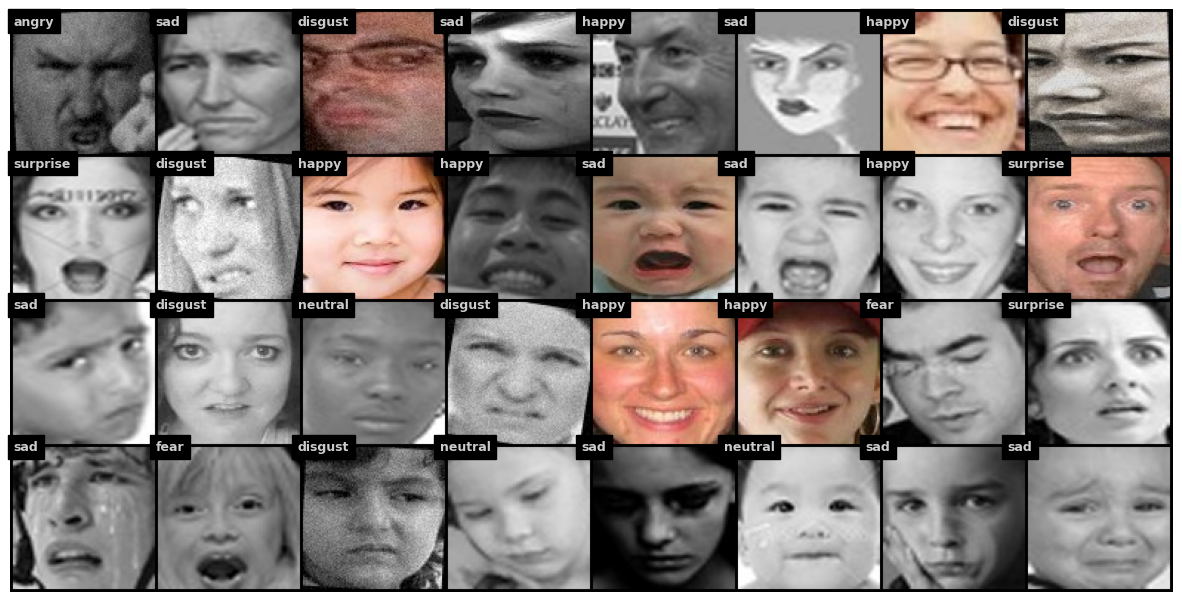

In [12]:
show_batch(dataloader_valid)

# ZERO SHOT & CLIP + Interpretabilité

In [14]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zl5xifsn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zl5xifsn
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 48.1 MB/s  0:00:08m0:00:0100:01
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=1403534f5c43c4029fee8b41980e30fe0d6372ba1c1bb029b6e8f9adf7e62ea5
  Stored in directory: /tmp/pip-ephem-wheel-cache-voddgw7p/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cu

In [7]:
import torch
import clip
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) # CLIP (notamment la version ViT-B/32) a été entraîné sur des images de 224x224 pixels.

In [41]:
dataset_test_clip = FERDataset(fer, transform=preprocess, split = "test")

# --- Création des DataLoaders special pour clip ---
dataset_test_clip = DataLoader(
    dataset_test_clip,
    batch_size=32,
    shuffle=False,
    num_workers=0
    
)

In [42]:
emotions_prompt = {
    "neutral": "a neutral, expressionless face",
    "angry": "an angry, furious facial expression",
    "disgust": "a disgusted, repulsed face",
    "fear": "a scared, terrified person",
    "happy": "a happy, smiling face",
    "sad": "a sad, sorrowful face",
    "surprise": "a surprised, shocked facial expression"
}

ordered_emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
prompts = [f"a photo of {emotions_prompt[e]}" for e in ordered_emotions]
text_inputs = clip.tokenize(prompts).to(device)

# --- Boucle d'évaluation Zero-Shot ---
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(dataset_test_clip, desc="Inférence CLIP"):
        images = images.to(device)

        # Stockage des labels réels et conversion index to nom
        for l in labels:
            all_labels.append(idx_to_class[l.item()])

        # Inférence
        logits_per_image, _ = model(images, text_inputs)

        # Prédictions
        probs = logits_per_image.softmax(dim=-1).cpu()
        pred_indices = probs.argmax(axis=-1)

        # Stockage des prédictions et conversion index to nom
        for p in pred_indices:
            all_preds.append(idx_to_class[p.item()])

# --- Résultats ---

print(f"\nAccuracy : {accuracy_score(all_labels, all_preds):.4f}")
print("\n")
print("\nRapport de classification détaillé :")
print(classification_report(all_labels, all_preds))

Inférence CLIP: 100%|██████████| 156/156 [00:38<00:00,  4.11it/s]



Accuracy : 0.4200



Rapport de classification détaillé :
              precision    recall  f1-score   support

       angry       0.33      0.62      0.43       592
     disgust       0.55      0.21      0.30       592
        fear       0.13      0.09      0.11       592
       happy       0.93      0.40      0.56      1140
     neutral       0.41      0.32      0.36       817
         sad       0.31      0.66      0.42       653
    surprise       0.56      0.67      0.61       592

    accuracy                           0.42      4978
   macro avg       0.46      0.42      0.40      4978
weighted avg       0.51      0.42      0.42      4978



# Resnet: Fine Tuning

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### ResNET 10 epochs training

In [ ]:
cnn_model = ResNet16_96(num_classes=7).to(device)

config = {
    "num_epochs": 10,
    "lr": 1e-3,
    "patience": 3,              # early stopping
    "min_delta": 1e-4,
    "checkpoint_path": "best_model.pth"
}

trainer = Trainer(cnn_model, dataloader_train, dataloader_valid, config)
trainer.train()
trainer.load_best_model()

#### ResNET 100 epochs training

In [ ]:
cnn_model = ResNet16_96(num_classes=7).to(device)

config = {
    "num_epochs": 100,
    "lr": 1e-3,
    "patience": 3,              # early stopping
    "min_delta": 1e-4,
    "checkpoint_path": "best_model.pth"
}

trainer = Trainer(cnn_model, dataloader_train, dataloader_valid, config)
trainer.train()
trainer.load_best_model()

## CNN: From Scratch

#### CNN 40 epochs training

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_529/1585182067.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=(self.device.type == "cuda"))


Progression Totale:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

/tmp/ipykernel_529/1585182067.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device.type == "cuda")):
/tmp/ipykernel_529/1585182067.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device.type == "cuda")):


Epoch 2 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 10 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 11 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 12 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 13 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 14 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 15 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 16 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 17 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 18 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 19 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 20 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 21 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 22 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 23 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 24 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 25 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 26 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 27 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 28 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Epoch 29 [Train]:   0%|          | 0/1244 [00:00<?, ?it/s]

Arrêt précoce à l'époque 29


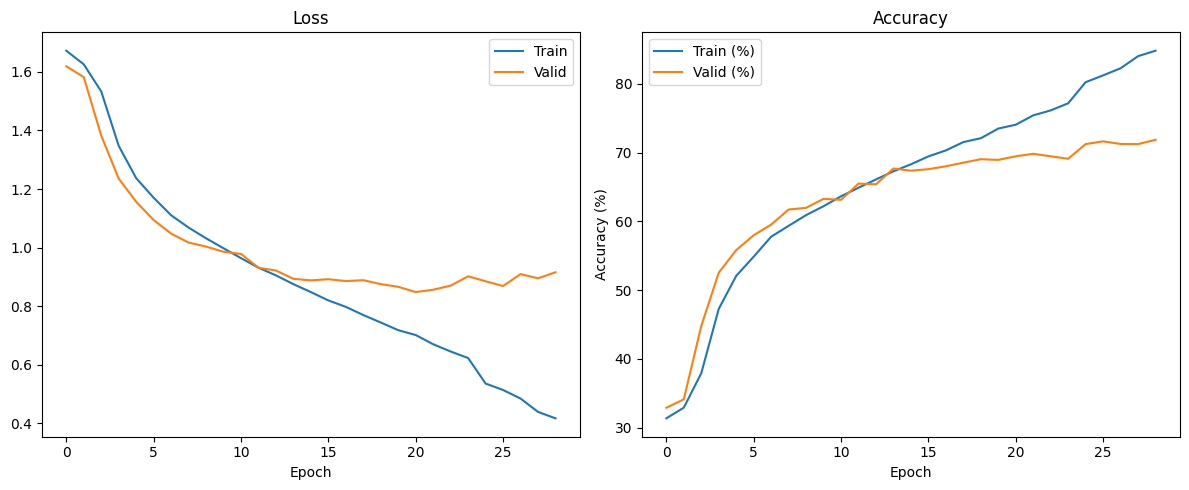

Best val loss: 0.8484941705580681


/tmp/ipykernel_529/1585182067.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.config["checkpoint_path"], map_location=self.device)


In [24]:
config = {
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "num_epochs": 40,
    "patience": 8,
    "min_delta": 1e-4,
    "checkpoint_path": "best_emotion_cnn.pt"
}

model = EmotionCNN(num_classes=7, base_channels=32)

# Optionnel: class weights si dataset déséquilibré
# Si tu as déjà une fonction compute_class_weights(train_dataset)
# class_weights = compute_class_weights(train_dataset, num_classes=7)
class_weights = None

trainer = Trainer(model, dataloader_train, dataloader_valid, config, class_weights=class_weights)
trainer.train()

best_loss = trainer.load_best_model()
print("Best val loss:", best_loss)


## Evaluation on test set

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

def evaluate_on_testset(models: list, dataset_test, batch_size=32, class_names=None):
    """
    Évalue plusieurs modèles sur un jeu de test jamais vu.

    Args:
        models (list): liste de tuples (model_name, model)
        dataset_test (Dataset): dataset PyTorch de test
        batch_size (int): batch size pour l'inférence
        class_names (list): noms des classes (optionnel)

    Returns:
        dict: résultats par modèle
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loader = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False
    )

    results = {}

    for model_name, model in models:
        print(f"\n===== Évaluation du modèle : {model_name} =====")

        model.to(device)
        model.eval()

        y_true = []
        y_pred = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                preds = outputs.argmax(dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # ---- Métriques ----
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
        recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        results[model_name] = {
            "accuracy": acc,
            "precision_macro": precision,
            "recall_macro": recall,
            "f1_macro": f1,
            "confusion_matrix": cm
        }

        # ---- Affichage texte ----
        print(f"Accuracy  : {acc*100:.2f}%")
        print(f"Precision : {precision:.4f}")
        print(f"Recall    : {recall:.4f}")
        print(f"F1-score  : {f1:.4f}")

        # ---- Matrice de confusion ----
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=class_names
        )
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Matrice de confusion – {model_name}")
        plt.show()

    return results


## Charger les modèles entrainés

In [28]:
from models import EmotionCNN, ResNet16_96
model_scratch = EmotionCNN(num_classes=7)
model_scratch.load_state_dict(torch.load("best_emotion_cnn.pt")["model_state_dict"])

#RESNET
model_ft = ResNet16_96(num_classes=7)
model_ft.load_state_dict(torch.load("best_model_resnet.pth")["model_state_dict"])


/tmp/ipykernel_529/3875056143.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_scratch.load_state_dict(torch.load("best_emotion_cnn.pt")["model_state_dict"])
/tmp/i

<All keys matched successfully>

#### Lancer l'evaluation


===== Évaluation du modèle : From Scratch =====
Accuracy  : 70.83%
Precision : 0.7032
Recall    : 0.6868
F1-score  : 0.6882


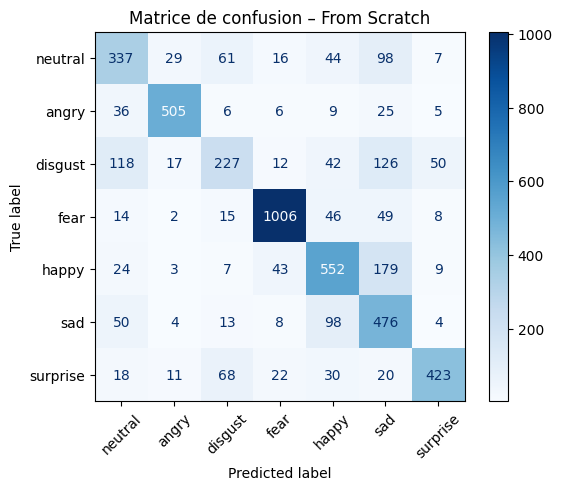


===== Évaluation du modèle : Fine-Tuning =====
Accuracy  : 68.44%
Precision : 0.6718
Recall    : 0.6663
F1-score  : 0.6672


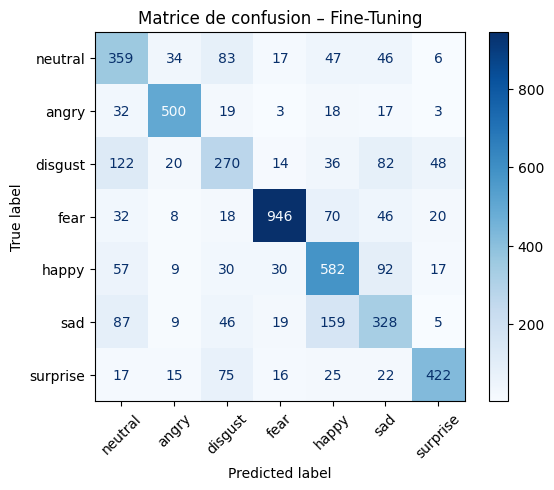

In [29]:
# models = [
#     ("From Scratch", model_scratch),
#     ("Fine-Tuning", model_ft),
# ]
models = [
    ("From Scratch", model_scratch),
    ("Fine-Tuning", model_ft)
]
class_names = ["neutral", "angry", "disgust", "fear", "happy", "sad", "surprise"]

results = evaluate_on_testset(
    models=models,
    dataset_test= dataset_test,
    batch_size=32,
    class_names=class_names
)


### Ne pas oublier que le modèle ResNet a été entrainé sur 10 epochs tandis que CNN from scratch sur 40 epochs